# 1 Data and package import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
data.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# 2 Data Inspection

## 2.1 Checking data types

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## 2.2 Transforming data

In [5]:
#Change values 0 and 1 to Yes and No in SeniorCitizen for consistent scaling
data['SeniorCitizen'] = data['SeniorCitizen'].map({1:'Yes',0:'No'})

#Change type of TotalCharges from object to numeric
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'],errors='coerce')

## 2.3 Checking levels in categorical variables

In [6]:
for col in data.columns[1:]:
    if data[col].dtype == 'object':
        print(f'{col} {data[col].unique()}')

gender ['Female' 'Male']
SeniorCitizen ['No' 'Yes']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ['No' 'Yes']


## 2.4 Checking missing values

In [7]:
#Check NA´s
data.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [8]:
#Inspect NA´s in dataframe
# data[data.TotalCharges.isna()]

In [9]:
#Insprect total charges when tenure=1
# data[data.tenure == 1]

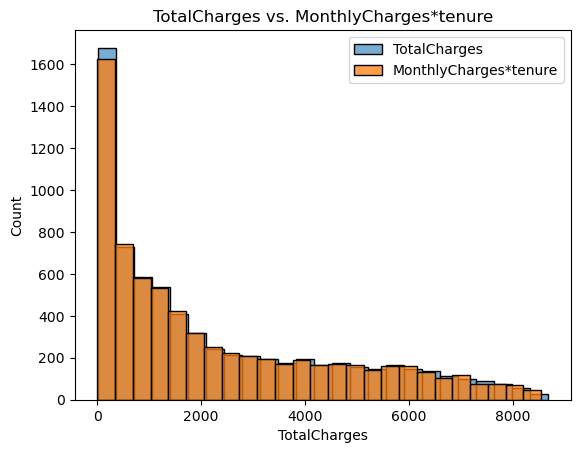

In [10]:
#Relationship total charges with monthlycharges * tenure
sns.histplot(data.TotalCharges,alpha=0.6,label='TotalCharges')
sns.histplot(data.MonthlyCharges*data.tenure,label='MonthlyCharges*tenure')
plt.title('TotalCharges vs. MonthlyCharges*tenure')
plt.legend()
plt.show()

In [11]:
#Replace monthly and total charges values with 0 where tenure = 0
data.loc[data['tenure'] == 0, 'MonthlyCharges'] = 0
data.loc[data['TotalCharges'].isna(), 'TotalCharges'] = 0

All Na´s in total charges have a monthly charges of 0. When you check the total charges with tenure == 1, total charges is the product of monthly charges times tenure. Its unclear why customers with tenure = 0 already have monthly charges when the total charges with tenure = 1 is the same as in monthly charges. Therefore Na´s and monthly charges in tenure = 0 will be replaced by 0.

In [12]:
data.shape

(7043, 21)

## 2.5 Checking duplicates

In [13]:
data.duplicated().sum()

0

## 2.6 Delete reduntant variables

In [14]:
#Delete customerID - reduntant variable
data = data.drop('customerID',axis=1)

# 3 Churn Analysis

## 3.1 Churn Rate

 Customers who have a one year contract churn within their minimal contract duration. Its unclear why. Therefore it is assumend that these customers are outliers and will be deleted for data consistency.

In [15]:
# Proportion of customers with a one year contract, which churn within minimal contract duration
np.divide(data[(data.tenure <= 12) & (data.Churn == 'Yes') & (data.Contract == 'One year')]['Contract'].count(),
          data[(data.Churn == 'Yes') & (data.Contract == 'One year')]['Contract'].count()).round(2)

0.08

In [16]:
# Delete customers with a one year contract and churn within minimal contract duration
data = data[~((data.tenure <= 12) & (data.Churn == 'Yes') & (data.Contract == 'One year'))]

In [17]:
#Total Churn (1st Level)
(data[data.Churn == 'Yes']['Churn'].count() / len(data)).round(2)

0.26

In [18]:
#Total Churn Rate per month
(data[data.Churn == 'Yes']['Churn'].count() / 72).round()


26.0

In [19]:
# Churn Rate per Contract type (2nd Level)
(data[data.Churn == 'Yes']['Contract'].value_counts() / data.Contract.value_counts()).round(2)

Contract
Month-to-month    0.43
One year          0.10
Two year          0.03
Name: count, dtype: float64

## 3.3 Distribution Churn among tenure

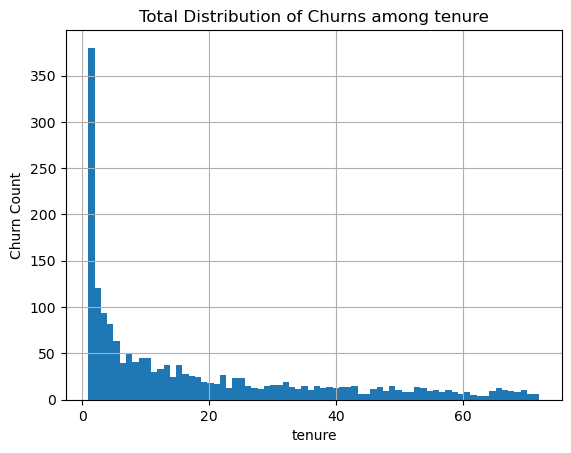

In [20]:
# Distribution churn among tenure
plt.hist(data=data[data.Churn == 'Yes'],x='tenure',bins=72)
plt.xticks(ticks=np.arange(min(data.tenure),max(data.tenure),3))
plt.title('Total Distribution of Churns among tenure')
plt.xlabel('tenure')
plt.ylabel('Churn Count')
plt.xticks(ticks=np.arange(0,72,20))
plt.grid()
plt.show()

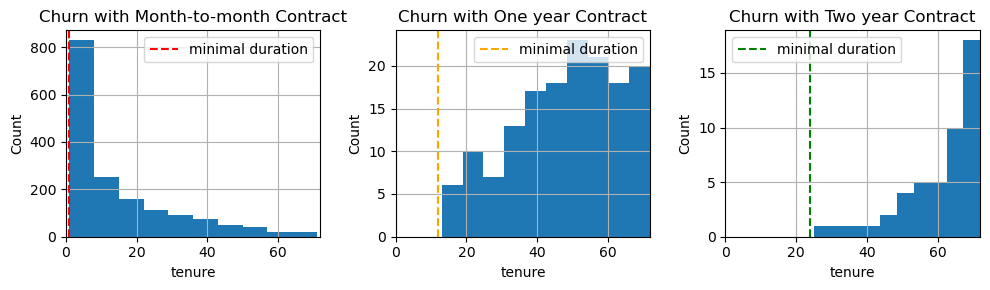

In [21]:
#Churn Distribution among Contract Types and
contract_types = ('Month-to-month','One year','Two year')

plt.figure(figsize=(10,3))
for i, contract_type in enumerate(contract_types):
    plt.subplot(1, 3, i + 1)
    plt.hist(data[(data.Churn == 'Yes') & (data.Contract == contract_type)]['tenure'], bins=10)
    plt.title(f'Churn with {contract_type} Contract')
    plt.xlabel('tenure')
    plt.ylabel('Count')
    plt.grid()
    plt.xlim(0,72)

    if contract_type == 'Month-to-month':
        plt.axvline(1,color='red',linestyle='--',label='minimal duration')
    elif contract_type == 'One year':
        plt.axvline(12,color='orange',linestyle='--',label='minimal duration')
    else:
        plt.axvline(24,color='green',linestyle='--',label='minimal duration')
    plt.legend()
  
plt.tight_layout()
plt.show()

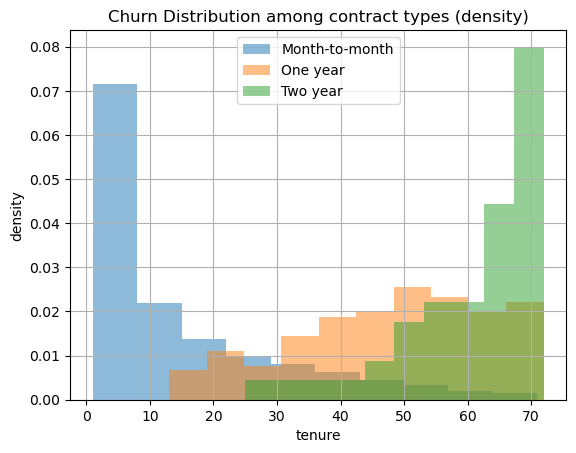

In [22]:
#Churn Distribution among contract types (density)
plt.hist(data=data[(data.Churn == 'Yes') & (data.Contract == 'Month-to-month')],x='tenure',bins=10,density=True,alpha=0.5,label='Month-to-month')
plt.hist(data=data[(data.Churn == 'Yes') & (data.Contract == 'One year')],x='tenure',bins=10,density=True,alpha=0.5,label='One year')
plt.hist(data=data[(data.Churn == 'Yes') & (data.Contract == 'Two year')],x='tenure',bins=10,density=True,alpha=0.5,label='Two year')
plt.title('Churn Distribution among contract types (density)')
plt.legend()
plt.grid()
plt.ylabel('density')
plt.xlabel('tenure')

plt.show()

In [23]:
#Decription of contract types
for type in contract_types:
    print(f'{type}')
    print(data[(data.Contract == type) & (data.Churn == 'Yes')]['tenure'].describe().round())

Month-to-month
count    1655.0
mean       14.0
std        16.0
min         1.0
25%         2.0
50%         7.0
75%        21.0
max        71.0
Name: tenure, dtype: float64
One year
count    153.0
mean      48.0
std       16.0
min       13.0
25%       38.0
50%       51.0
75%       60.0
max       72.0
Name: tenure, dtype: float64
Two year
count    48.0
mean     61.0
std      11.0
min      25.0
25%      56.0
50%      66.0
75%      70.0
max      72.0
Name: tenure, dtype: float64


As shown in the description above, churns based on different time periods among the contract types. Customers who have a Month-to-month contract churn within a period of 70 months, customers who have a one year contract within 59 months and customers with a two year contract within 47 months.For this reason, churn among contract types must be defined per month to avoid a biased view.

In [24]:
# Churn Rate per contract type and month (3rd Level)
print('month_to_month_churn_per_month', np.round((1655 / (3875*70))*100,2))
print('one_year_churn_per_month', np.round((166 / (1495*70))*100,2))
print('two_year_churn_per_month', np.round((48 / (1695*47))*100,2))

month_to_month_churn_per_month 0.61
one_year_churn_per_month 0.16
two_year_churn_per_month 0.06


### 3.3.1 Binning tenure to find optimal churn proportion

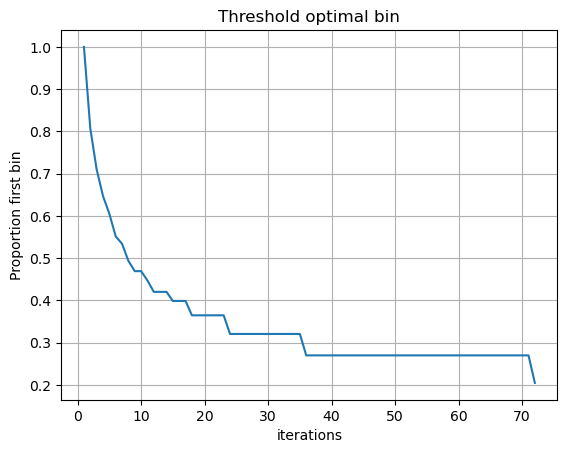

In [25]:
#Finding threshold for optimal bin
data_bins = data.copy()
data_bins = data_bins[data_bins.Churn == 'Yes']

results = []
bins = np.arange(1,73,1)

for i in bins:
    data_bins['tenure_bin'] = pd.cut(x=data_bins['tenure'],bins=i)
    value_counts = data_bins.tenure_bin.value_counts(normalize=True)
    results.append(value_counts.iloc[0])

plt.plot(bins,results)
plt.xlabel('iterations')
plt.ylabel('Proportion first bin')
plt.title('Threshold optimal bin')
plt.grid()

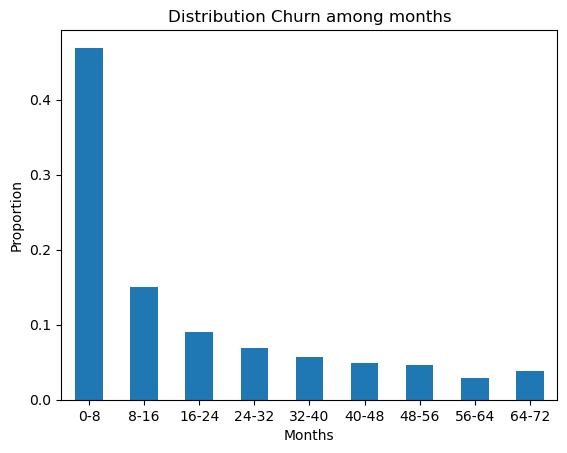

In [49]:
##Binning tenure with practical bin
data_bins['tenure_bin'] = pd.cut(x=data_bins['tenure'],bins=np.arange(0,73,8),labels=['0-8','8-16','16-24','24-32','32-40','40-48','48-56','56-64','64-72'])

data_bins.tenure_bin.value_counts(normalize=True).sort_index().plot.bar()
plt.title('Distribution Churn among months')
plt.ylabel('Proportion')
plt.xlabel('Months')
plt.xticks(rotation=0)
plt.show()

In [27]:
data_bins.tenure_bin.value_counts(normalize=True).sort_index().round(2)

tenure_bin
0-8      0.47
8-16     0.15
16-24    0.09
24-32    0.07
32-40    0.06
40-48    0.05
48-56    0.05
56-64    0.03
64-72    0.04
Name: proportion, dtype: float64

# 4 Correlation Analysis

In [28]:
#Define Cramers´s V

from scipy.stats import chi2_contingency

def cramersv (x,y):

    #Chi2
    chi2_conting = pd.crosstab(x,y)
    chi2, p, _, _ = chi2_contingency(chi2_conting)

    #CramersV
    n = chi2_conting.sum().sum()
    r, k = chi2_conting.shape
    m = min(r - 1, k - 1)
    v = np.sqrt(chi2 / (n * m))
    
    return v,p

## 4.1 Distribution Churn by categorical variables

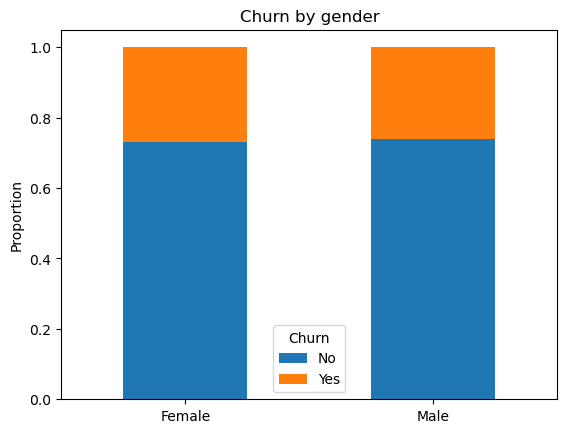

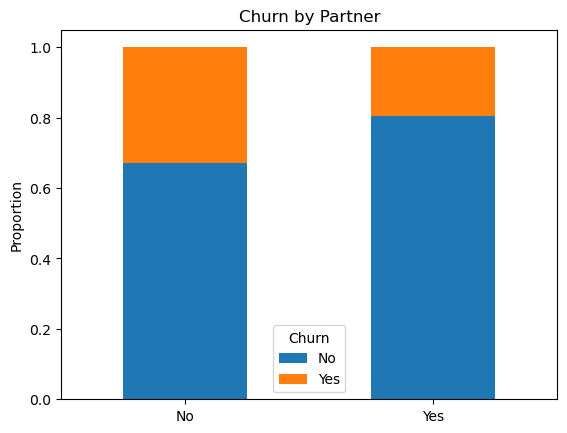

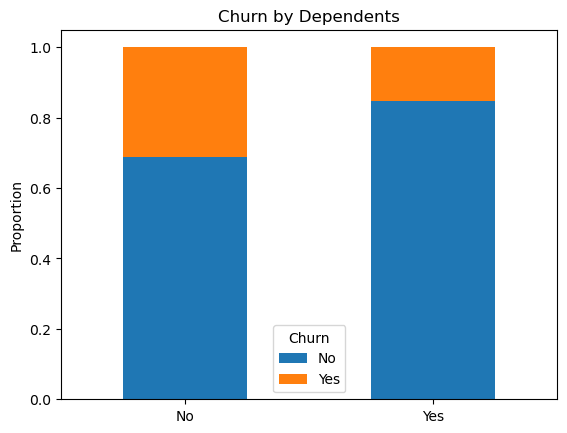

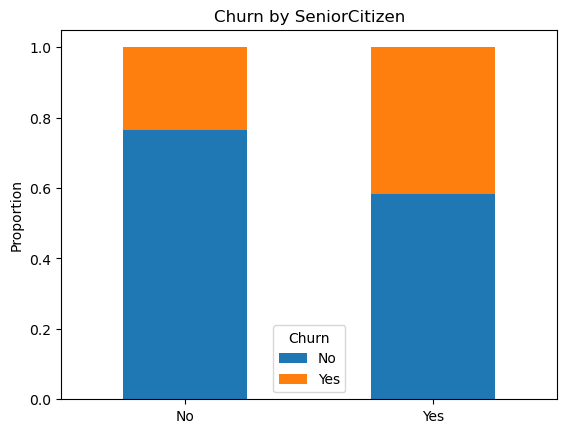

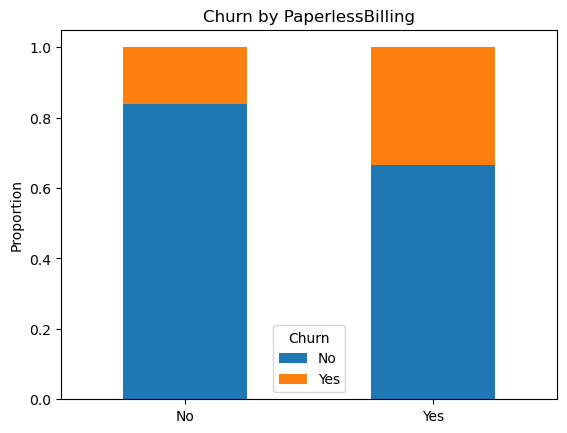

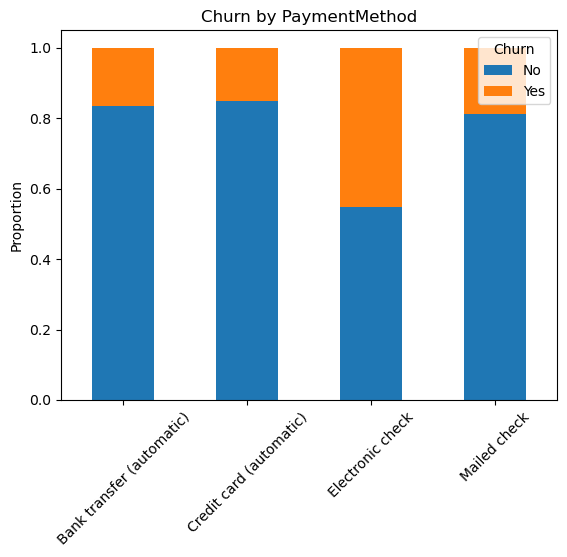

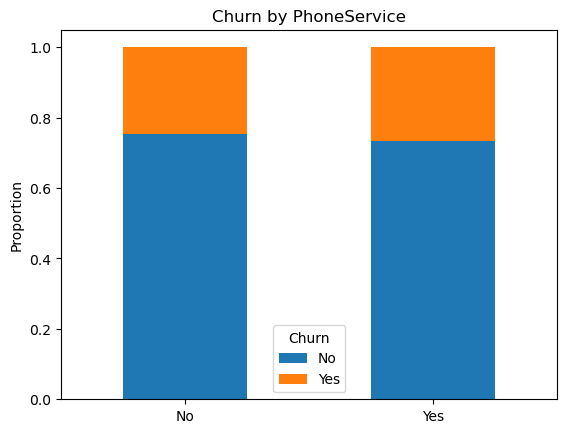

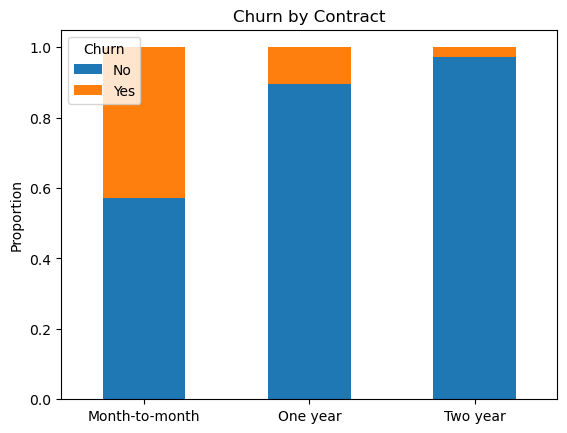

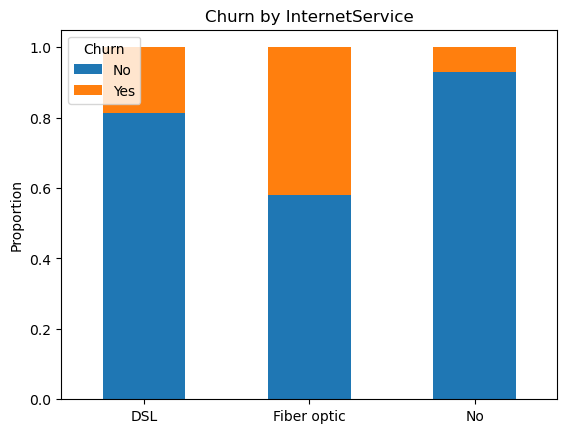

In [29]:
for col in ['gender','Partner','Dependents','SeniorCitizen','PaperlessBilling','PaymentMethod','PhoneService','Contract','InternetService']:
    data.groupby(col)['Churn'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)
    plt.xticks(rotation=0 if col != 'PaymentMethod' else 45)
    plt.title(f'Churn by {col}')
    plt.ylabel('Proportion')
    plt.xlabel('')


### 4.1.1 Correlation Churn by categorical variables

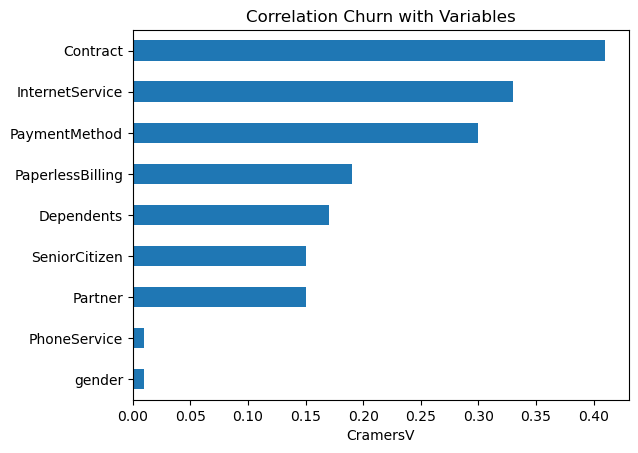

           Variable  CramersV  p-value
0          Contract      0.41   0.0000
1   InternetService      0.33   0.0000
2     PaymentMethod      0.30   0.0000
3  PaperlessBilling      0.19   0.0000
4        Dependents      0.17   0.0000
5           Partner      0.15   0.0000
6     SeniorCitizen      0.15   0.0000
7            gender      0.01   0.4504
8      PhoneService      0.01   0.3128


In [30]:
#CramersV, p-value for categorical variables
var_churn_list = []

for col in ['gender','Partner','Dependents','SeniorCitizen','PaperlessBilling','PaymentMethod','PhoneService','Contract','InternetService']:
    v,p = cramersv(data[col],data['Churn'])
    var_churn_list.append({'Variable':col,'CramersV':v.round(2),'p-value':p.round(4)})

#DataFrame
var_churn_df = pd.DataFrame(var_churn_list).sort_values(by='CramersV',ascending=False).reset_index(drop=True)
var_churn_df.sort_values(by='CramersV').plot.barh(x='Variable',y='CramersV',legend=False)
plt.title('Correlation Churn with Variables')
plt.xlabel('CramersV')
plt.ylabel('')
plt.show()

print(var_churn_df)

### 4.1.2 Correlation Matrix

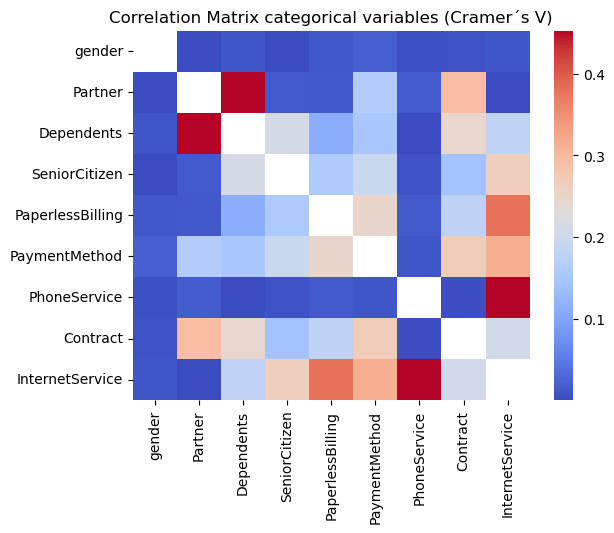

In [31]:
from itertools import combinations

cat_var_list = ['gender','Partner','Dependents','SeniorCitizen','PaperlessBilling','PaymentMethod','PhoneService','Contract','InternetService']

#Create empty Dataframe
corr_matrix = pd.DataFrame(index=cat_var_list, columns=cat_var_list, dtype=float)

#Iterate throu combinations
for col1, col2 in combinations(cat_var_list, 2):
    v = cramersv(data[col1], data[col2])

    #Append values to Dataframe
    corr_matrix.loc[col1, col2] = v[0]
    corr_matrix.loc[col2, col1] = v[0]

#Plot
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.ylabel('')
plt.xlabel('')
plt.title('Correlation Matrix categorical variables (Cramer´s V)')
plt.show()

## 4.2 Distribution Churn by categorical variables with level no internet service

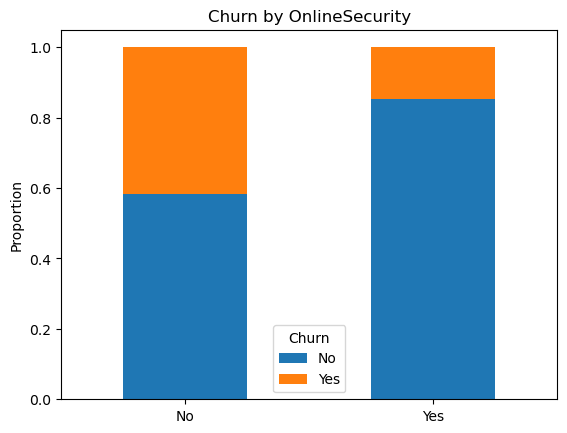

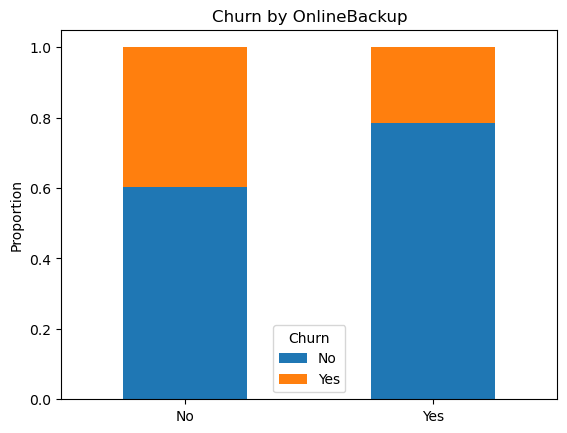

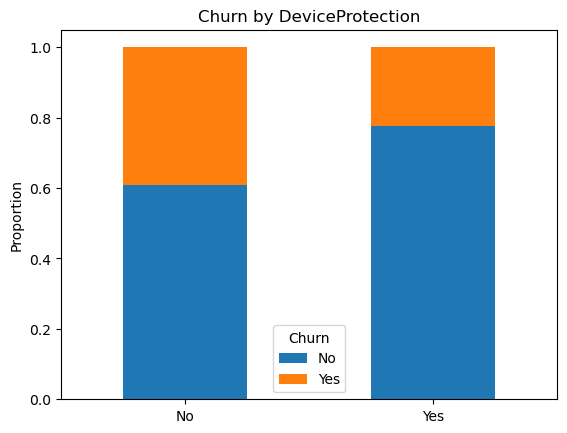

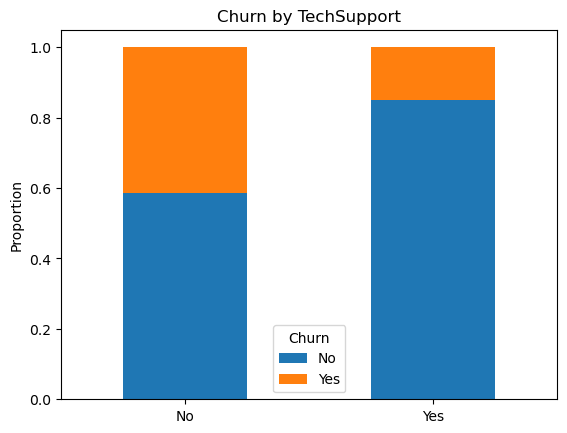

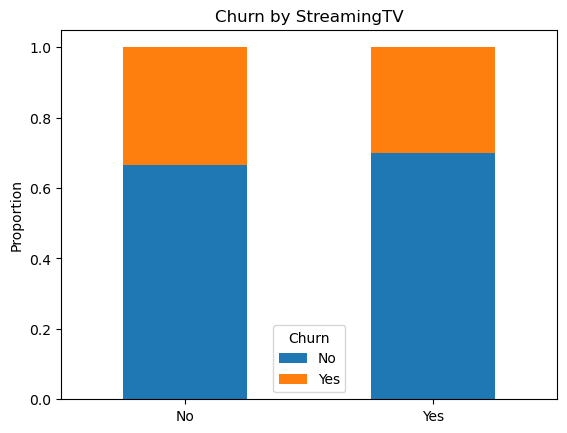

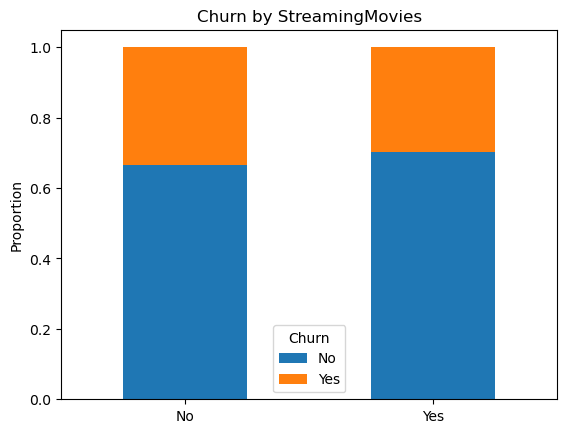

In [32]:
'''
Rows with no internet service were deleted to prevent spurious correlation. 
For example, customers without internet service can not have online backup or online security.
'''

for col in ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']:
    data[data.InternetService != 'No'].groupby(col)['Churn'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)
    plt.xticks(rotation=0 if col != 'PaymentMethod' else 45)
    plt.title(f'Churn by {col}')
    plt.ylabel('Proportion')
    plt.xlabel('')

### 4.2.1 Correlation Churn by categorical variables with level no internet service

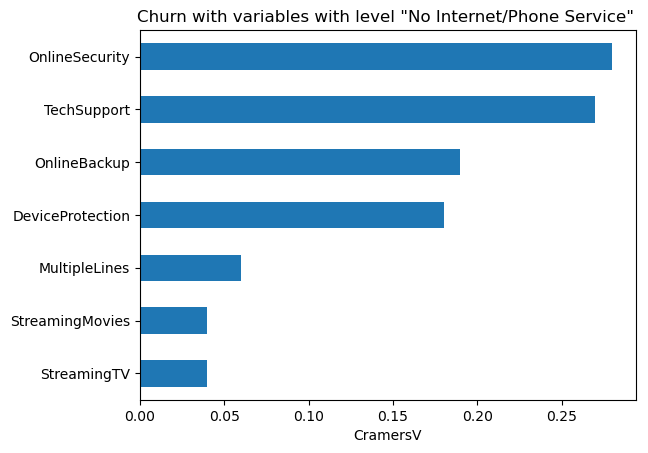

Length data_filter: 5508 of 7030
           Variable  CramersV  p-value
0    OnlineSecurity      0.28   0.0000
1       TechSupport      0.27   0.0000
2      OnlineBackup      0.19   0.0000
3  DeviceProtection      0.18   0.0000
4     MultipleLines      0.06   0.0001
5       StreamingTV      0.04   0.0053
6   StreamingMovies      0.04   0.0029


In [33]:
#Filter data on InternetService not 'No'
data_filter = data[data.InternetService != 'No']

#Subset of data
data_subset = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','MultipleLines']

#CramersV, p-value for filtered variables
var_churn_list = []
for col in data_subset:
    v,p = cramersv(data_filter[col],data_filter['Churn'])
    var_churn_list.append({'Variable':col,'CramersV':v.round(2),'p-value':p.round(4)})

var_churn_df = pd.DataFrame(var_churn_list).sort_values(by='CramersV',ascending=False).reset_index(drop=True)
var_churn_df.sort_values(by='CramersV').plot.barh(x='Variable',y='CramersV',legend=False)
plt.title('Churn with variables with level "No Internet/Phone Service" ')
plt.xlabel('CramersV')
plt.ylabel('')
plt.show()

print(f'Length data_filter: {len(data_filter)} of {len(data)}')
print(var_churn_df)

In [34]:
'''
columns = ['OnlineSecurity', 'OnlineBackup', 'TechSupport', 'DeviceProtection']
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i, col in enumerate(columns):
    ax = axes[i // 2, i % 2]
    data.groupby(data[col])['Churn'].value_counts(normalize=True).unstack().plot.bar(stacked=True, ax=ax)
    ax.set_title(f'Churn by {col}')  
    ax.tick_params(axis='x', rotation=0)
    ax.set_xlabel('')
    ax.set_ylabel('Proportion')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

'''

"\ncolumns = ['OnlineSecurity', 'OnlineBackup', 'TechSupport', 'DeviceProtection']\nfig, axes = plt.subplots(2, 2, figsize=(10, 8))\n\nfor i, col in enumerate(columns):\n    ax = axes[i // 2, i % 2]\n    data.groupby(data[col])['Churn'].value_counts(normalize=True).unstack().plot.bar(stacked=True, ax=ax)\n    ax.set_title(f'Churn by {col}')  \n    ax.tick_params(axis='x', rotation=0)\n    ax.set_xlabel('')\n    ax.set_ylabel('Proportion')\n    ax.legend(loc='lower right')\n\nplt.tight_layout()\nplt.show()\n\n"

### 4.2.2 Correlation Matrix

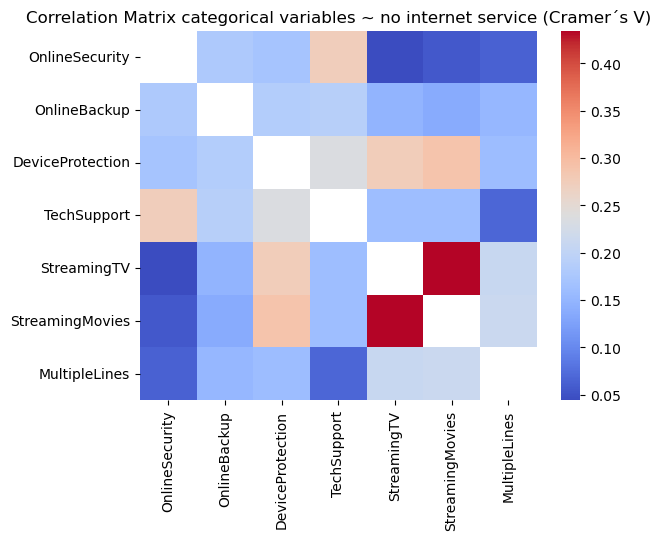

In [35]:
from itertools import combinations

#Create empty Dataframe
corr_matrix = pd.DataFrame(index=data_subset, columns=data_subset, dtype=float)

#Iterate throu combinations
for col1, col2 in combinations(data_subset, 2):
    v = cramersv(data_filter[col1], data_filter[col2])

    #Append values to Dataframe
    corr_matrix.loc[col1, col2] = v[0]
    corr_matrix.loc[col2, col1] = v[0]

#Plot
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.ylabel('')
plt.xlabel('')
plt.title('Correlation Matrix categorical variables ~ no internet service (Cramer´s V)')
plt.show()

## 4.3 Distribution Churn by categorical variables ~ tenure <= 8 months

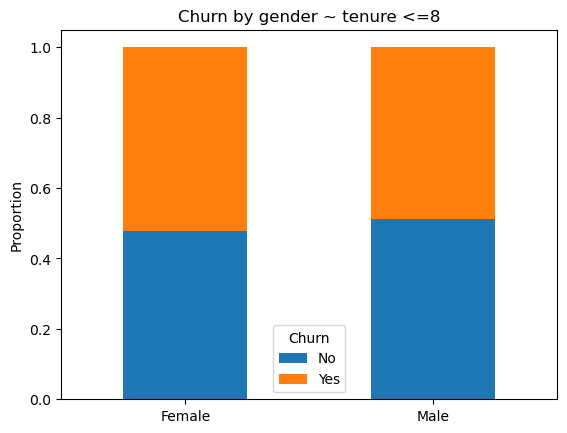

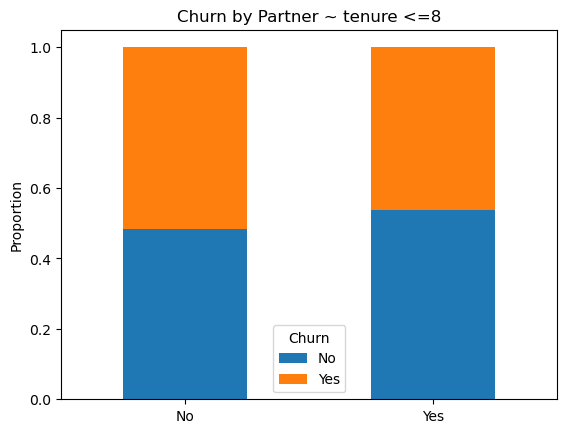

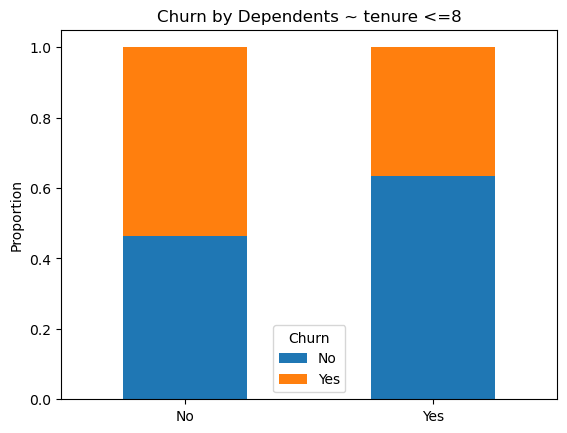

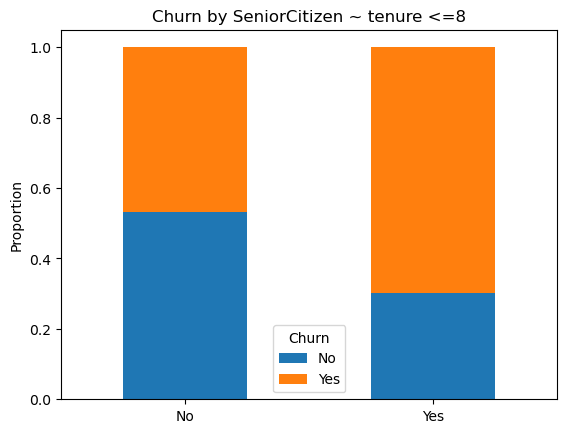

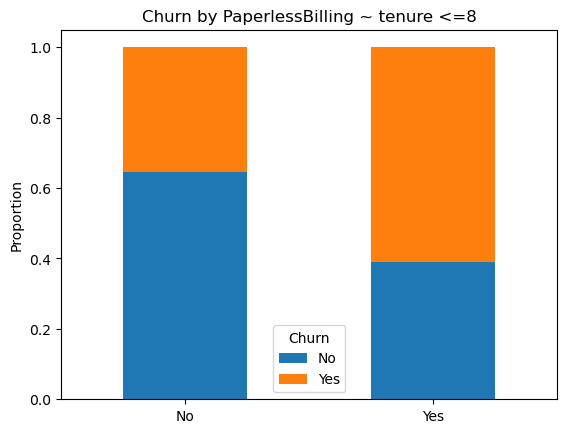

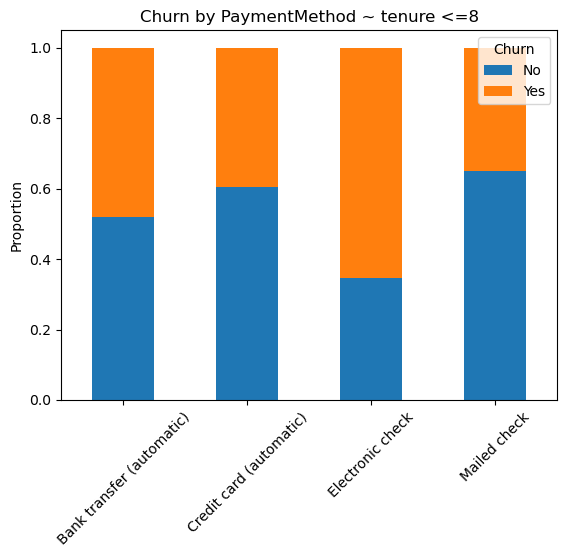

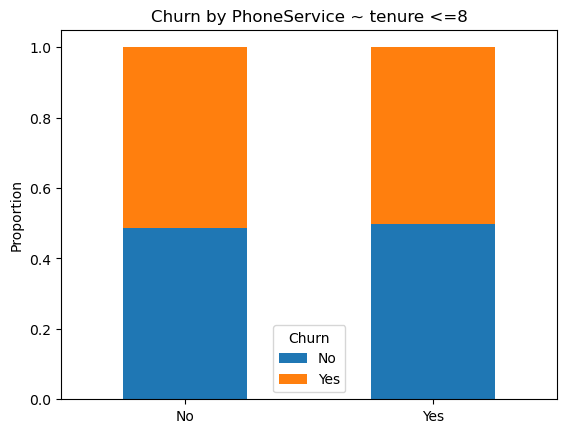

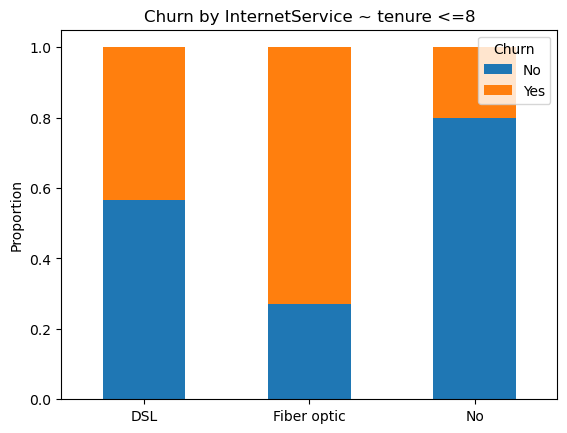

In [36]:
for col in ['gender','Partner','Dependents','SeniorCitizen','PaperlessBilling','PaymentMethod','PhoneService','InternetService']:
    data[data.tenure <= 8].groupby(col)['Churn'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)
    plt.xticks(rotation=0 if col != 'PaymentMethod' else 45)
    plt.title(f'Churn by {col} ~ tenure <=8')
    plt.ylabel('Proportion')
    plt.xlabel('')

### 4.3.1 Correlation Churn by categorical variables ~ tenure <= 8 months

In [37]:
var_churn_list = []

for col in ['gender','Partner','Dependents','SeniorCitizen','PaperlessBilling','PaymentMethod','PhoneService','InternetService']:
    v,p = cramersv(data[data.tenure <= 8][col],data['Churn'])
    var_churn_list.append({'Variable':col,'CramersV':v.round(2),'p-value':p.round(4)})

var_churn_df = pd.DataFrame(var_churn_list).sort_values(by='CramersV',ascending=False).reset_index(drop=True)
print(var_churn_df)

           Variable  CramersV  p-value
0   InternetService      0.42   0.0000
1     PaymentMethod      0.28   0.0000
2  PaperlessBilling      0.25   0.0000
3     SeniorCitizen      0.16   0.0000
4        Dependents      0.13   0.0000
5           Partner      0.05   0.0548
6            gender      0.03   0.1701
7      PhoneService      0.01   0.8287


## 4.4 Distribution Churn by categorical variables with level no internet service ~ tenure <=8 months

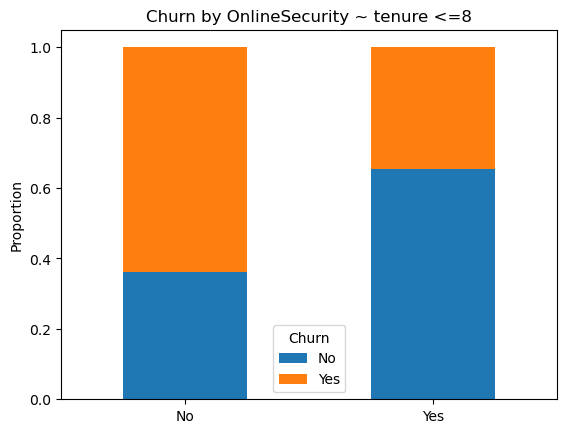

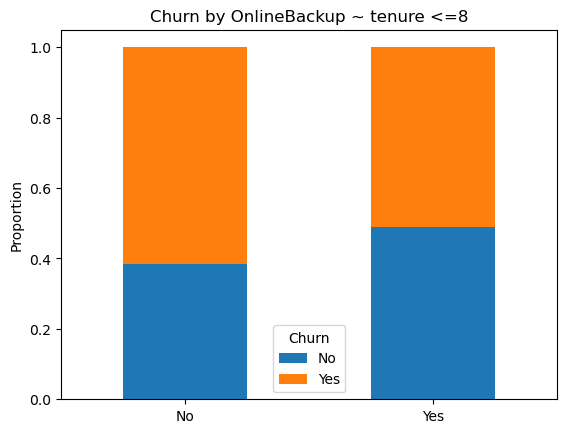

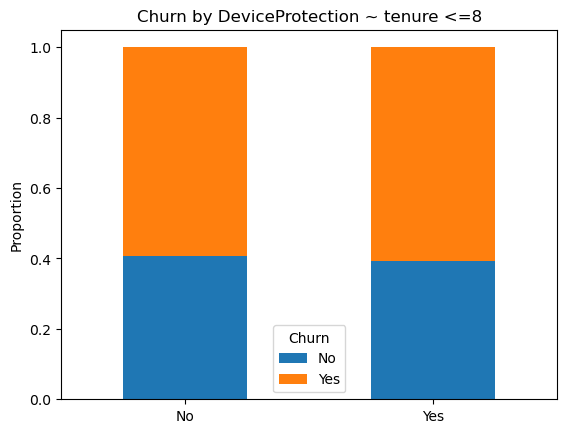

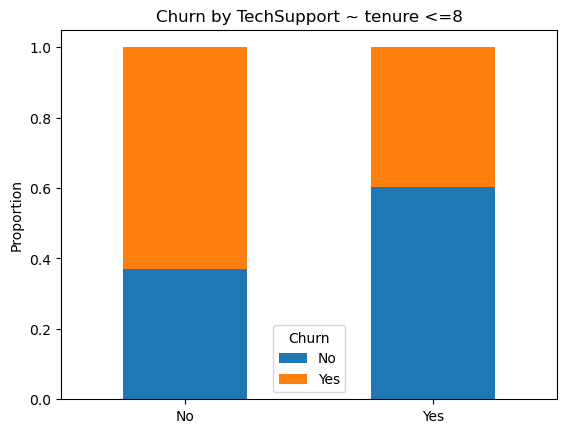

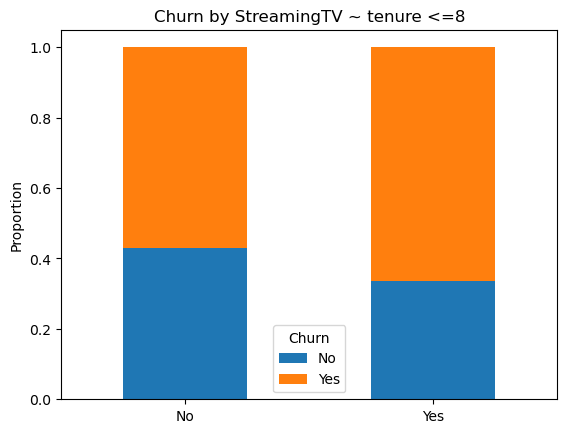

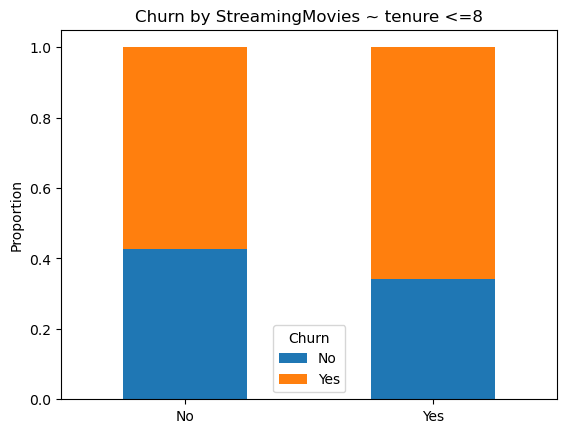

In [38]:
for col in ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']:
    data[(data.InternetService != 'No') & (data.tenure <= 8)].groupby(col)['Churn'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)
    plt.xticks(rotation=0 if col != 'PaymentMethod' else 45)
    plt.title(f'Churn by {col} ~ tenure <=8')
    plt.ylabel('Proportion')
    plt.xlabel('')

In [39]:
'''
#Image

fig, ax = plt.subplots(3, 2, figsize=(10, 10))

# Flatten the 2D array of axes for easier indexing
axes = ax.flatten()

for i, col in enumerate(['InternetService', 'OnlineSecurity', 'TechSupport', 'OnlineBackup', 'DeviceProtection']):
    col_groupby = data_filter.groupby(col)['Churn'].value_counts(normalize=True).unstack()
    col_groupby.plot(kind='bar', stacked=True, ax=axes[i])
    
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Proportion')
    axes[i].set_title(f'Churn by {col} ~ tenure <= 8 months')
    axes[i].legend(title='Churn', loc='lower right')
    axes[i].tick_params(axis='x', rotation=0)

fig.delaxes(axes[-1])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

'''


"\n#Image\n\nfig, ax = plt.subplots(3, 2, figsize=(10, 10))\n\n# Flatten the 2D array of axes for easier indexing\naxes = ax.flatten()\n\nfor i, col in enumerate(['InternetService', 'OnlineSecurity', 'TechSupport', 'OnlineBackup', 'DeviceProtection']):\n    col_groupby = data_filter.groupby(col)['Churn'].value_counts(normalize=True).unstack()\n    col_groupby.plot(kind='bar', stacked=True, ax=axes[i])\n    \n    axes[i].set_xlabel('')\n    axes[i].set_ylabel('Proportion')\n    axes[i].set_title(f'Churn by {col} ~ tenure <= 8 months')\n    axes[i].legend(title='Churn', loc='lower right')\n    axes[i].tick_params(axis='x', rotation=0)\n\nfig.delaxes(axes[-1])\n\n# Adjust layout for better spacing\nplt.tight_layout()\nplt.show()\n\n"

### 4.4.1 Correlation Churn by categorical variables with level not internet service ~ tenure <= 8 months

In [40]:
var_churn_list = []

for col in ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']:
    v, p = cramersv(data[(data.tenure <= 8) & (data.InternetService != 'No')][col], 
                     data[(data.tenure <= 8) & (data.InternetService != 'No')]['Churn'])
    var_churn_list.append({'Variable':col,'CramersV':v.round(2),'p-value':p.round(4)})

var_churn_df = pd.DataFrame(var_churn_list).sort_values(by='CramersV',ascending=False).reset_index(drop=True)
print(var_churn_df)

           Variable  CramersV  p-value
0    OnlineSecurity      0.21   0.0000
1       TechSupport      0.17   0.0000
2      OnlineBackup      0.08   0.0031
3       StreamingTV      0.08   0.0031
4   StreamingMovies      0.08   0.0061
5  DeviceProtection      0.01   0.7486


# 5 Financial Aspects

## 5.1 Sum TotalCharges/TotalCharges by InternetService

In [41]:
#Sum of TotalCharges
data.TotalCharges.sum()

16050464.95

In [42]:
#Statistics MonhtlyCharges by Internet Service
data.groupby('InternetService')['MonthlyCharges'].agg(['sum','mean','median'])

,sum,mean,median
InternetService,,,
DSL,139967.70,57.981649,56.15
Fiber optic,283083.25,91.494263,91.65
No,31957.25,20.996879,20.15


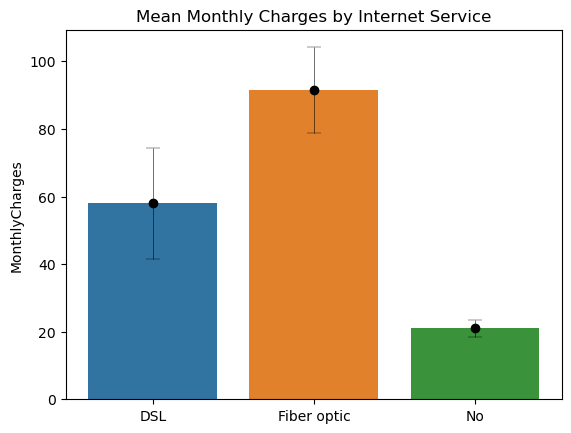

In [43]:
#Mean Monthly Charges by Internet Service
mean = data.groupby('InternetService')['MonthlyCharges'].mean()
std = data.groupby('InternetService')['MonthlyCharges'].std()

sns.barplot(data=data,x='InternetService',y='MonthlyCharges')
plt.errorbar(x=mean.index, y=mean, yerr=std, fmt='o', capsize=5,color='black',capthick=0.3,elinewidth=0.4)
plt.title('Mean Monthly Charges by Internet Service')
plt.xlabel('')
plt.show()

## 5.2 Distribution MonthlyCharges by Churn

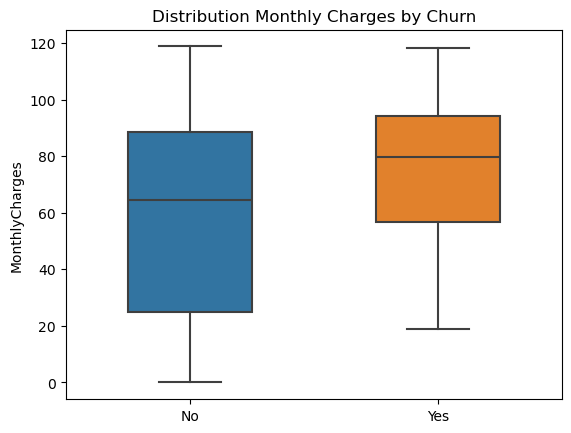

In [44]:
#Distribution Monthly Charges by Churn
sns.boxplot(data=data,x='Churn',y='MonthlyCharges',width=0.5)
plt.title('Distribution Monthly Charges by Churn')
plt.xlabel('')
plt.show()

## 5.3 Mean/Distribution TotalCharges by InternetServivce among tenure

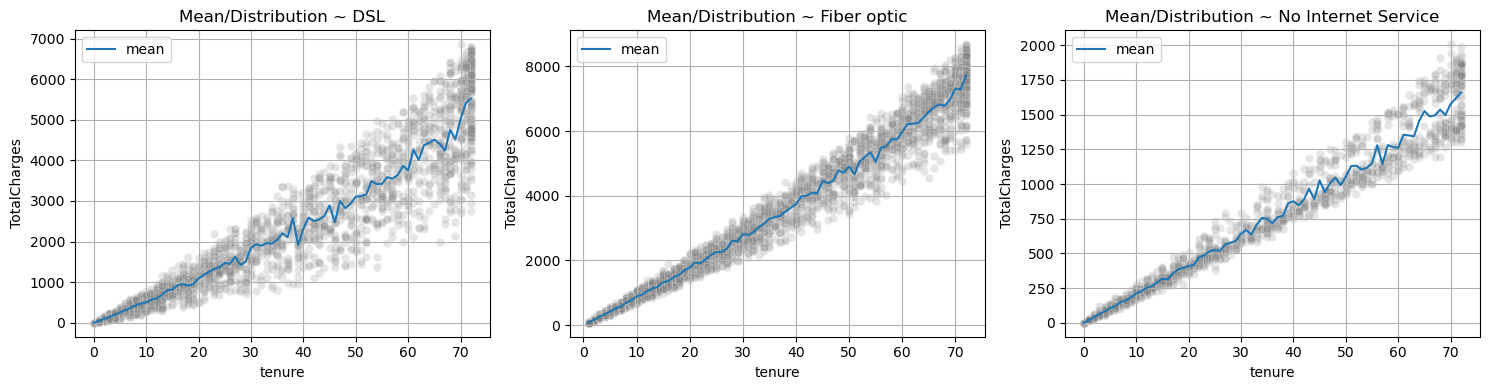

In [45]:
#Mean and Distribution of Total Charges among tenure

fig, ax = plt.subplots(1,3,figsize=(15,4))

#Subplot 1
data[data.InternetService == 'DSL'].groupby('tenure')['TotalCharges'].mean().plot(label='mean',ax=ax[0],title='Mean/Distribution ~ DSL')
sns.scatterplot(data=data[data.InternetService == 'DSL'],x='tenure',y='TotalCharges',alpha=0.2,ax=ax[0],color='grey')
ax[0].grid()

#Subplot 2
data[data.InternetService == 'Fiber optic'].groupby('tenure')['TotalCharges'].mean().plot(label='mean',ax=ax[1],title='Mean/Distribution ~ Fiber optic')
sns.scatterplot(data=data[data.InternetService == 'Fiber optic'],x='tenure',y='TotalCharges',alpha=0.2,ax=ax[1],color='grey')
ax[1].grid()

#Subplot 3
data[data.InternetService == 'No'].groupby('tenure')['TotalCharges'].mean().plot(label='mean',ax=ax[2],title='Mean/Distribution ~ No Internet Service')
sns.scatterplot(data=data[data.InternetService == 'No'],x='tenure',y='TotalCharges',alpha=0.2,ax=ax[2],color='grey')
ax[2].grid()

plt.tight_layout()
plt.show()

## 5.4 Mean/Distribution MonthlyCharges by InternetService among tenure

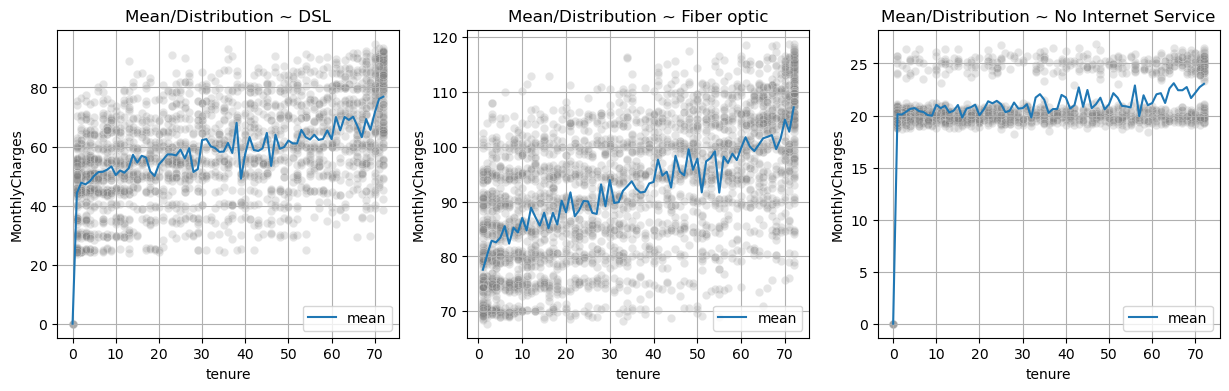

In [46]:
#Mean and Distribution of Monthly Charges among tenure

fig, ax = plt.subplots(1,3,figsize=(15,4))

#Subplot 1
data[data.InternetService == 'DSL'].groupby('tenure')['MonthlyCharges'].mean().plot(label='mean',ax=ax[0],title='Mean/Distribution ~ DSL')
sns.scatterplot(data=data[data.InternetService == 'DSL'],x='tenure',y='MonthlyCharges',alpha=0.2,ax=ax[0],color='grey')
ax[0].grid()

#Subplot 2
data[data.InternetService == 'Fiber optic'].groupby('tenure')['MonthlyCharges'].mean().plot(label='mean',ax=ax[1],title='Mean/Distribution ~ Fiber optic')
sns.scatterplot(data=data[data.InternetService == 'Fiber optic'],x='tenure',y='MonthlyCharges',alpha=0.2,ax=ax[1], color='grey')
ax[1].grid()
ax[1].legend(loc='lower right')

#Subplot 3
data[data.InternetService == 'No'].groupby('tenure')['MonthlyCharges'].mean().plot(label='mean',ax=ax[2],title='Mean/Distribution ~ No Internet Service')
sns.scatterplot(data=data[data.InternetService == 'No'],x='tenure',y='MonthlyCharges',alpha=0.2,ax=ax[2], color='grey')
ax[2].grid()